# **Projet 7 : Implémentez un modèle de scoring - Modélisation**

**Table des matières**<a id='toc0_'></a>    
- 1. [Introduction](#toc1_)    
  - 1.1. [Contexte](#toc1_1_)    
  - 1.2. [Mission](#toc1_2_)    
  - 1.3. [Objectif du Notebook](#toc1_3_)    
- 2. [Installation des librairies](#toc2_)    
- 3. [Importation des données](#toc3_)    
  - 3.1. [Importation des datasets](#toc3_1_)    
  - 3.2. [Création de la configuration des modèles](#toc3_2_)    
- 4. [Sélection du dataset](#toc4_)    
- 5. [Optimisation des modèles](#toc5_)    
  - 5.1. [Séparation des données](#toc5_1_)    
  - 5.2. [LogisticRegression](#toc5_2_)    
  - 5.3. [RandomForestClassifier](#toc5_3_)    
  - 5.4. [XGBoostClassifier](#toc5_4_)    
  - 5.5. [DecisionTreeClassifier](#toc5_5_)    
- 6. [Comparaison des modèles](#toc6_)    
  - 6.1. [Visualisation](#toc6_1_)    
  - 6.2. [Bilan](#toc6_2_)    
- 7. [Preparation d'une Pipeline et du threshold correspondant :](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Introduction](#toc0_)
### 1.1. <a id='toc1_1_'></a>[Contexte](#toc0_)

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifier la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement.

### 1.2. <a id='toc1_2_'></a>[Mission](#toc0_)

1. Construction d'un modèle de scoring donnant une prédiction sur la probabilité de faillite d'un client de façon automatique.
2. Construction d'un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
3. Mise en production du modèle de scoring de prédiction à l’aide d’une API, ainsi que du dashboard interactif appelant l’API pour les prédictions.

### 1.3. <a id='toc1_3_'></a>[Objectif du Notebook](#toc0_)

Dans ce Notebook nous verrons : 
1. <u>**La sélection de la meilleure compléttion des valeurs manqantes**</u>
    - train_mean_imputed (imputation par la moyenne)
    - train_median_imputed (imputation par la médianne)
    - train_mode_imputed (imputation par le mode)
2. <u>**L'entrainnement et l'optimisation des modèles de classification**</u>

|Modèle|Caractéristiques|Paramètres|
|-|-|-|
|LogisticRegression|Modèle linéaire, renvoie la probabilté d'appartenance à la classe|'C': de 1*e-5  à 1*e2|
|RandomForestClassifier|Modèle ensembliste, construction d'arbres de décision sur des variables alétoirement et se base sur l'aggrégation de l'ensemble|'n_estimators': entre 50 et 200,<br>'max_depth': entre 1 et 30|
|XGBoostClassifier|Modèle ensembliste basé sur l'algorithme XGBoost, offre une haute performance en classification|learning_rate': entre 0.01 et 1,<br>'n_estimators': entre 50 et 200,<br>'max_depth': entre 1 et 15|
|DecisionTreeClassifier|Division de l'ensemble de données en fonction des caractéristiques pour créer une structure arborescente de décisions|'max_depth': entre 1 et 30<br>'min_samples_leaf': entre 1 et 30|

*Plusieurs étapes seront mises en place :*
- Etape 1 : Préprocessing du dataset.

     - Séparation en ensemble de train et de test pour l'optimisation des hyperparamètres des modèles.  

    - Gestion du déséquilibre de classe au sein de l'ensemble de train :  
    Utilisation de SMOTE (Synthetic Minority Over-sampling Technique), module génèrant des exemples de données synthétiques pour la classe minoritaire en interpolant les caractéristiques des exemples existants et de leurs voisins les plus proches, ce qui équilibre les classes dans un ensemble de données déséquilibré en apprentissage automatique (cf schéma ci-dessous).

    - Normalisation des données à l'aide de StandarScaler.

- Etape 2 : Apprentissage des modèles par validation croisée.

    - Evaluation des modèles de manières robuste (réduction du risque de surajustement).  
    - Utilisation de différentes métriques (**accuracy, recall, precision, f1_score, AUC, score_metier**) à la fois sur l'ensemble de validation et sur un ensemble de test pour départager les performances des modèles. (l'optimisation des hyperparamètres se fera sur le score_métier prenant en compte la différence de coût entre les faux positifs et les faux négatifs). 
    - Optimisation des hyperparamètres des modèles à l'aide d'hyperopt.  

- Etape 3 : Suivi des résultats avec MLFlow.

    - Facilitation du suivi des entrainnements et de la comparaison des performances des modèles.

3. <u>**La sélection du meilleur modèle pour le déploiement dans l'API**</u>

## 2. <a id='toc2_'></a>[Installation des librairies](#toc0_)

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from hyperopt import hp

import mlflow

from Fonctions import fct_data, fct_modelisation

## 3. <a id='toc3_'></a>[Importation des données](#toc0_)
### 3.1. <a id='toc3_1_'></a>[Importation des datasets](#toc0_)

In [2]:
# Chargement des datasets : 
ls = ['train_mean_imputed', 'train_median_imputed', 'train_mode_imputed']
chemin = '2. Sauvegardes'
dict_data = {}


for fichier in ls: 
    f = fct_data.chargement_pickle(
        name=fichier,
        chemin=chemin,
    )
    
    dict_data[fichier] = f

del ls, chemin, fichier, f

### 3.2. <a id='toc3_2_'></a>[Création de la configuration des modèles](#toc0_)

In [3]:
# Initialisation des dictionnaires de configurations : 

models = [
    {
        'name': 'LogisticRegression',
        'model': LogisticRegression(random_state=42),
        'space': {
            'C': hp.choice('C', [x for x in np.logspace(-5, 2, 20)]),
            'threshold': hp.uniform('threshold', 0, 1),
            }
        },
    {
        'name': 'RandomForest',
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'space': {
            'max_depth': hp.choice('max_depth', [int(x) for x in np.arange(1, 30)]),
            'n_estimators': hp.choice('n_estimators', [int(x) for x in np.arange(50, 200)]),
            'threshold': hp.uniform('threshold', 0, 1),
            }
        },
    {
        'name': 'XGBoost',
        'model': XGBClassifier(random_state=42, n_jobs=-1),
        'space': {
            'learning_rate': hp.choice('learning_rate', [x for x in np.logspace(-2, 0, 10)]),
            'max_depth': hp.choice('max_depth', [int(x) for x in np.arange(1, 15)]),
            'n_estimators': hp.choice('n_estimators', [int(x) for x in np.arange(50, 200)]),
            'threshold': hp.uniform('threshold', 0, 1),
        }
    },
    {
        'name': 'DecisionTreeClassifier',
        'model': DecisionTreeClassifier(random_state=42),
        'space': {
            'max_depth':  hp.choice('max_depth', [int(x) for x in np.arange(1, 30)]),
            'min_samples_leaf': hp.choice('min_samples_leaf', [int(x) for x in np.arange(1, 30)]),
                    'threshold': hp.uniform('threshold', 0, 1),
        }
    }
    ]


## 4. <a id='toc4_'></a>[Sélection du dataset](#toc0_)
Ici nous testerons les 3 datasets avec un modèle simple de classification (LogisticRegression ici) afin de déterminer lequel à le plus de potentiel pour la suite de l'étude. 

In [3]:
# Selection du Datasets le plus prometteur : 

# Création du dictionnaire de resultats : 
result = {}

for name, df in dict_data.items(): 
    
    # Création du modèle : 
    model = LogisticRegression(random_state=42)
    
    # Preprocessing de df : 
    X_train, X_test, y_train, y_test = fct_modelisation.preprocess_data(data=df)
    
    # Entrainnement et prediction : 
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    # Enregistrement de l'accuracy : 
    result[name] = accuracy_score(y_test, y_pred)

# Sélection du meilleur dataset : 
best_df = None
best_accuracy = 0 

for name, accuracy in result.items(): 
    if accuracy > best_accuracy: 
        best_df = name

print(f"Le dataset sélectionné est {best_df}")

data = dict_data[best_df]

del accuracy, best_accuracy, best_df, df, dict_data, model, name, X_test, X_train, y_test, y_train, y_pred, result

Le dataset sélectionné est train_mode_imputed


Pour la suite, nous utiliserons donc le dataset train_mode_imputed, qui possède les meilleurs résultats avec LogisticRegression.  

Nous entrainnenrons et optimiserons l'ensemble des modèles séléectionnés précedemment sur ce jeu de données afin de comparer les résultats et de sélectionner le meilleur modèle pour la suite du projet. 

## 5. <a id='toc5_'></a>[Optimisation des modèles](#toc0_)
### 5.1. <a id='toc5_1_'></a>[Séparation des données](#toc0_)
Ici, nous allons séparer nos données en ensemble d'entrainnement et de test. 

In [6]:
X_train, X_test, y_train, y_test = fct_modelisation.preprocess_data(
    data=data,
        )

### 5.2. <a id='toc5_2_'></a>[LogisticRegression](#toc0_)

In [6]:
# Séléction de l'experience : 
mlflow.set_experiment('Comparaison_des_modèles')

# Sélection et entrainement de LogisticRegression : 
model_config = models[0]

print(f"Entrainement de {model_config['name']}")

fct_modelisation.search_best_model(
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        dict_model=model_config,
        run_name=model_config['name'],
        max_evals=20,
        )

2024/01/06 15:02:22 INFO mlflow.tracking.fluent: Experiment with name 'Comparaison_des_modèles' does not exist. Creating a new experiment.


Entrainement de LogisticRegression
100%|██████████| 20/20 [00:22<00:00,  1.15s/trial, best loss: 0.45886138854549585]


### 5.3. <a id='toc5_3_'></a>[RandomForestClassifier](#toc0_)

In [7]:
# Séléction de l'experience : 
mlflow.set_experiment('Comparaison_des_modèles')

# Sélection et entrainement de RandomForestClassifier : 
model_config = models[1]

print(f"Entrainement de {model_config['name']}")

fct_modelisation.search_best_model(
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        dict_model=model_config,
        run_name=model_config['name'],
        max_evals=20,
        )

Entrainement de RandomForest
100%|██████████| 20/20 [42:34<00:00, 127.71s/trial, best loss: 0.25755211052863825]


/Users/maxime/Library/Caches/pypoetry/virtualenvs/projet_7_ocr-XkMw7yxm-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/maxime/Library/Caches/pypoetry/virtualenvs/projet_7_ocr-XkMw7yxm-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### 5.4. <a id='toc5_4_'></a>[XGBoostClassifier](#toc0_)

In [8]:
# Séléction de l'experience : 
mlflow.set_experiment('Comparaison_des_modèles')

# Sélection et entrainement de XGBoostClassifier : 
model_config = models[2]

print(f"Entrainement de {model_config['name']}")

fct_modelisation.search_best_model(
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        dict_model=model_config,
        run_name=model_config['name'],
        max_evals=20,
        )

Entrainement de XGBoost
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [05:19<00:00, 15.97s/trial, best loss: 0.1838823722812118]


/Users/maxime/Library/Caches/pypoetry/virtualenvs/projet_7_ocr-XkMw7yxm-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/maxime/Library/Caches/pypoetry/virtualenvs/projet_7_ocr-XkMw7yxm-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### 5.5. <a id='toc5_5_'></a>[DecisionTreeClassifier](#toc0_)

In [9]:
# Séléction de l'experience : 
mlflow.set_experiment('Comparaison_des_modèles')

# Sélection et entrainement de DecisionTreeClassifier : 
model_config = models[3]

print(f"Entrainement de {model_config['name']}")

fct_modelisation.search_best_model(
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        dict_model=model_config,
        run_name=model_config['name'],
        max_evals=20,
        )

Entrainement de DecisionTreeClassifier
100%|██████████| 20/20 [05:11<00:00, 15.56s/trial, best loss: 0.3866636453810691]


/Users/maxime/Library/Caches/pypoetry/virtualenvs/projet_7_ocr-XkMw7yxm-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/maxime/Library/Caches/pypoetry/virtualenvs/projet_7_ocr-XkMw7yxm-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## 6. <a id='toc6_'></a>[Comparaison des modèles](#toc0_)
### 6.1. <a id='toc6_1_'></a>[Visualisation](#toc0_)

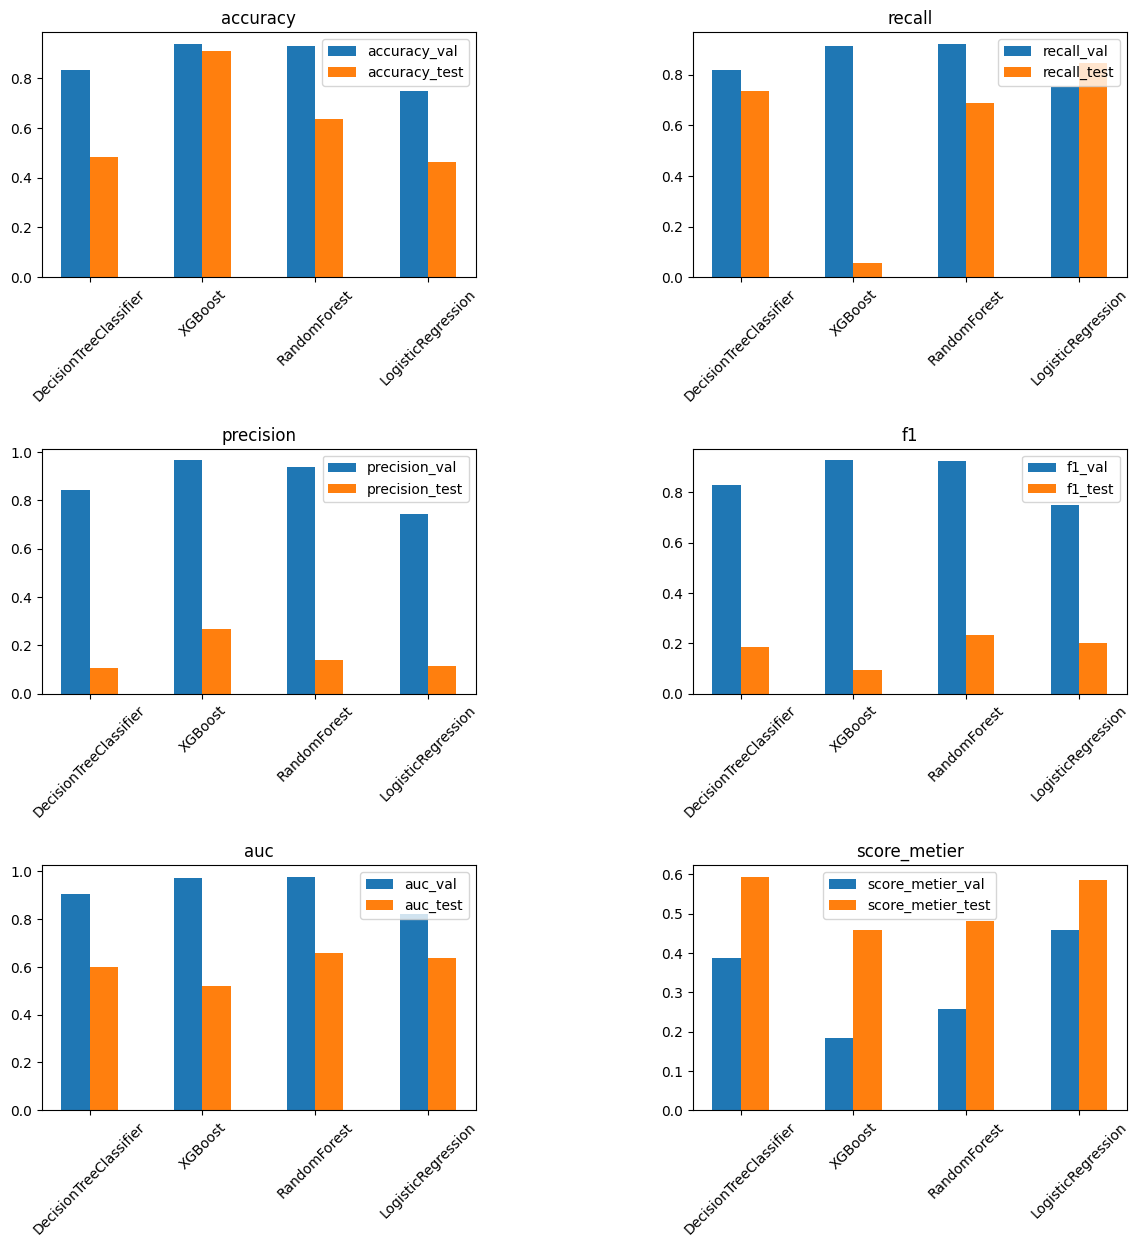

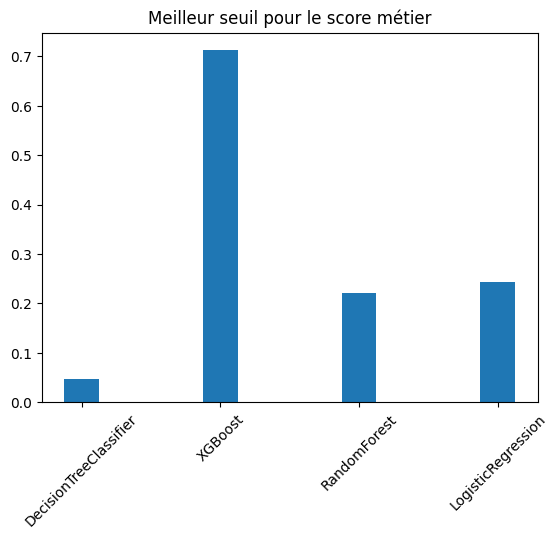

In [4]:
# Récupération des runs : 
runs = mlflow.search_runs(
    experiment_names=['Comparaison_des_modèles'],     
    )

ls_metrics = ['accuracy', 'recall', 'precision', 'f1', 'auc', 'score_metier']


# Récupération des données de comparaison : 
name = runs['tags.mlflow.runName'].tolist()
width = 0.25

# Récupération des données de comparaison : 
name = runs['tags.mlflow.runName'].tolist()
width = 0.25

# Calcul des lignes et colonnes : 
num_cols = 2
num_rows = (len(ls_metrics) + num_cols - 1) // num_cols

# Création de la figure : 
fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 14))

# Ajustement manuel de l'espacement entre les sous-graphiques : 
plt.subplots_adjust(wspace=0.5, hspace=0.7)

# Création des graphiques : 
for i, metric in enumerate(ls_metrics): 
    
    row = i // num_cols
    col = i % num_cols
    
    test = runs[f"metrics.{metric}_test"].tolist()
    val = runs[f"metrics.{metric}_val"].tolist()
    
    axs[row, col].bar(x=[x-width/2 for x in range(len(name))], height=val, width=width, label=f"{metric}_val")
    axs[row, col].bar(x=[x+width/2 for x in range(len(name))], height=test, width=width, label=f"{metric}_test")

    axs[row, col].set_xticks(range(len(name)))
    axs[row, col].set_xticklabels(name, rotation=45)
    axs[row, col].set_title(f"{metric}")
    axs[row, col].legend()
    
# Suppression des graphiques vides : 
if len(ls_metrics) % 2 == 1:
    fig.delaxes(axs[-1, -1])

plt.show()

# Graphique de threshold : 
threshold_ls = runs['metrics.threshold'].tolist()

plt.figure()

plt.bar(x=range(len(name)), height=threshold_ls, width=width)

plt.xticks(range(len(name)), name, rotation=45)
plt.title('Meilleur seuil pour le score métier')

plt.show()

del axs, col, fig, i, metric, num_cols, num_rows, row, test, val, width, name, ls_metrics, threshold_ls

**Rappel sur les metriques :**

|Métrique|Description|Utilisation|
|-|-|-|
|Accuracy|Mesure la proportion de prédictions correctes parmi toutes les prédictions|Indique la performance globale du modèle|
|Recall|Mesure la proportion de vrais positifs parmi tous les vrais positifs et faux négatifs|Utile pour évaluer la capacité du modèle à identifier tous les exemples positifs|
|Precision|Mesure la proportion de vrais positifs parmi tous les vrais positifs et faux positifs|Indique la précision du modèle lorsqu'il prédit la classe positive|
|F1 Score|Une métrique combinée de recall et precision, f1 = 2*((precision*recall)/(precision+recall))|Utile lorsque l'on veut trouver un équilibre entre recall et precision|
|AUC|Mesure la surface sous la courbe ROC (Receiver Operating Characteristic), qui représente le taux de vrais positifs par rapport au taux de faux positifs pour différentes valeurs seuil|Évalue la capacité du modèle à discriminer entre les classes|
|score_metier|1-fbeta_score|pondération : coût des faux negatifs 10 fois supérieur à celui des faux positifs|

Au regard des divers scores enregistrés avec MLflow lors de l'optimisation des hyperparamètres des modèles, nous choisirons le RandomForestClassifer comme modèle principal.  
Second meilleur au score métier (non loin du XGBoostClassifier), mais généralise gloablement mieux sur l'ensemble des autres métriques, il est don cplus équilibré.  
Cependant, pour une dernière évaluation décisive, nous examinerons une métrique supplémentaire : la RMSE (racine carrée de l'erreur quadratique moyenne) sur l'ensemble d'entraînement et de test de tous les modèles.

In [7]:
# Récupération de l'ensemble des modèles entrainés : 
dict_models = {}

for i in range(len(runs)): 
    dict_models[runs['tags.mlflow.runName'][i]] = mlflow.sklearn.load_model(f"{runs['artifact_uri'][i]}/best_model")
    

# Affichage des RMSE pour chaque modèle : 
for name, model in dict_models.items(): 
    print('--'*50)
    print(name)
    
    fct_modelisation.evaluate_model_rmse(
        model=model,
        X_train=X_train, 
        X_test=X_test, 
        y_train=y_train, 
        y_test=y_test,
    )

    print('--'*50)
    
del i, model, name, X_test, X_train, y_test, y_train

----------------------------------------------------------------------------------------------------
DecisionTreeClassifier
RMSE sur le train : 0.33861295995762414
RMSE sur le test : 0.438875406449557
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
XGBoost
RMSE sur le train : 0.0962380217867518
RMSE sur le test : 0.3192164238125911
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
RandomForest
RMSE sur le train : 0.05679618342470648
RMSE sur le test : 0.34555860699726526
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
LogisticRegressi

### 6.2. <a id='toc6_2_'></a>[Bilan](#toc0_)

Le modèle RandomForestClassifier affiche les plus faibles valeurs de RMSE tant sur l'ensemble d'entraînement (0.057) que sur l'ensemble de test (0.3456), démontrant ainsi sa robustesse et sa capacité à généraliser les prédictions.  
Par conséquent, le RandomForestClassifier est retenu comme le choix final.

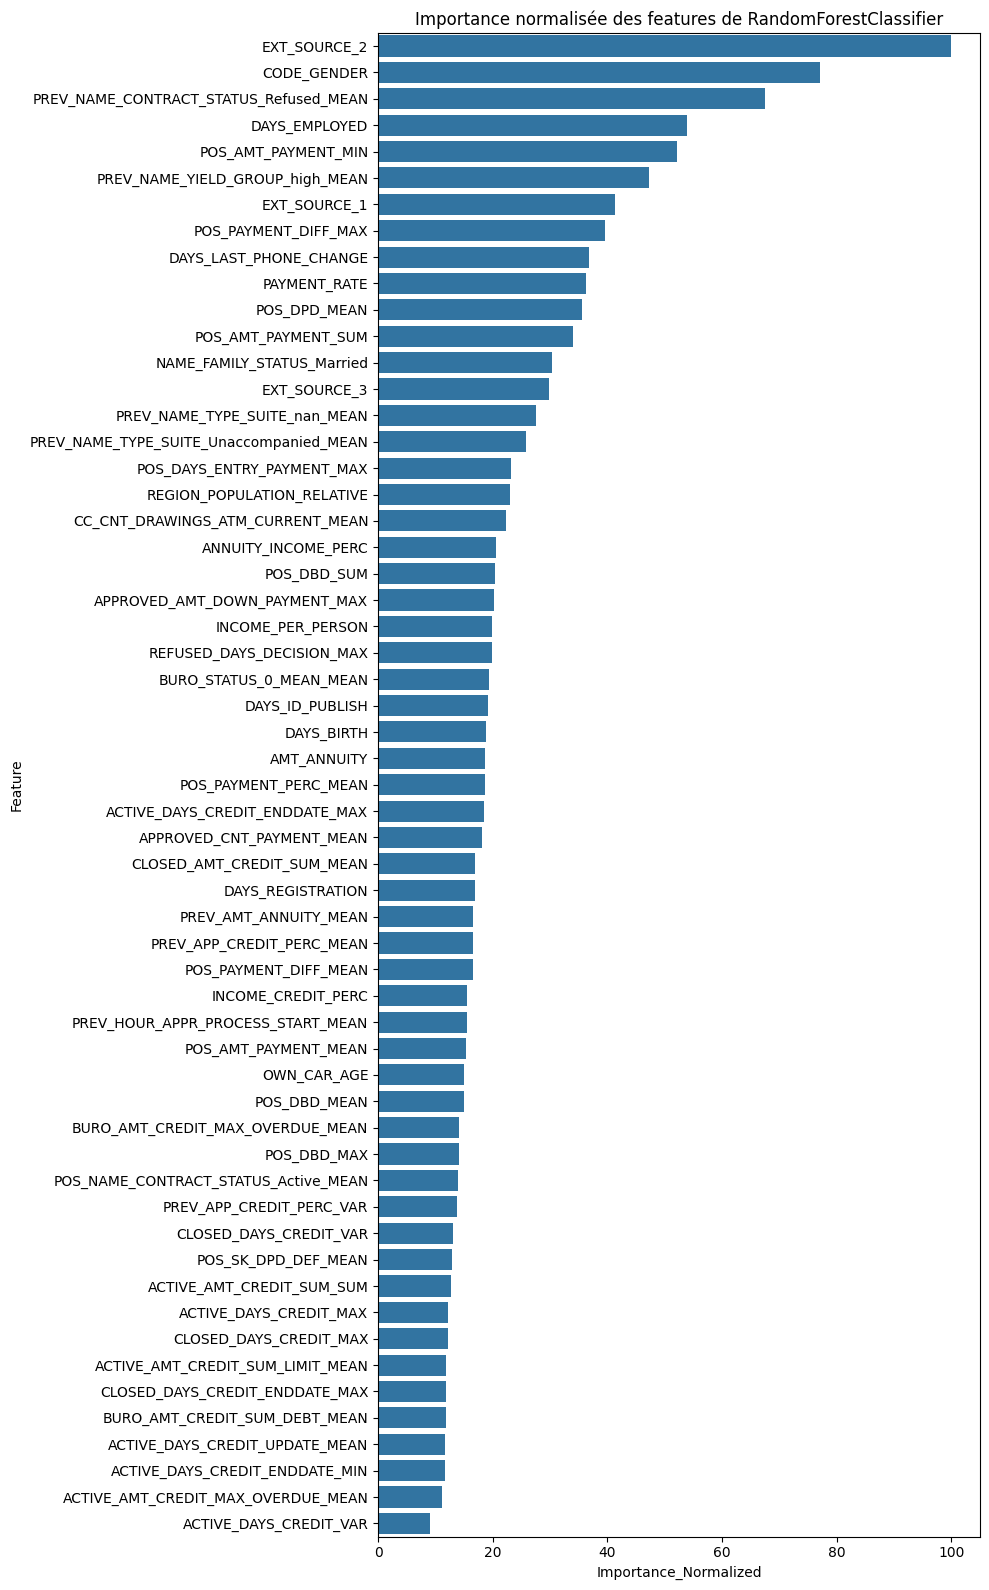

In [12]:
# Visualisation des features importances pour RandomForestClassifier : 

# Création d'un DataFrame : 
features_importances = pd.DataFrame({
    'Feature': [col for col in data.columns.to_list() if col != 'TARGET'],
    'Importance': dict_models['RandomForest'].feature_importances_,
    }
                                    )
# Normalisation des importances entre 0 et 100
max_importance = features_importances['Importance'].max()
features_importances['Importance_Normalized'] = (features_importances['Importance'] / max_importance) * 100

# Tri des valeurs normalisées
features_importances = features_importances.sort_values('Importance_Normalized', ascending=False).reset_index(drop=True)

# Création du graphique
plt.figure(figsize=(10, 16))

sns.barplot(
    x="Importance_Normalized",
    y='Feature',
    data=features_importances,
)

plt.title('Importance normalisée des features de RandomForestClassifier')
plt.tight_layout()

plt.show()

## 7. <a id='toc7_'></a>[Preparation d'une Pipeline et du threshold correspondant :](#toc0_)

Ici, nous allons préparer une pipeline déstinée au déploiement en production comprenant : 
- un StandardScaler
- Le modèle avec les meilleurs hyperparamètres entraînés.

Pour ce faire, nous devons également entraîner le StandardScaler en amont, dans les même conditions que lors de l'entrainement du modèle. 

Nous récuérerons également les seuils de décisions spécifiques trouvés lors de l'optimisation avec hyperopt. 


In [8]:
# Préparation du scaler : 

# Création d'un scaler :
scaler = StandardScaler()

# Séparation des données et de la Target : 
X = data.drop('TARGET', axis=1)
y = data['TARGET'].copy()
    
# Séparation en ensemble de train et test : 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
# Gestion du déséquilibre de classe avec SMOTE : 
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Entrainnement du scaler :
scaler.fit(X_train)

StandardScaler()

In [9]:
# Création et enregistrement de la pipeline et du seuil de pour chaque modèle : 
for name, model in dict_models.items():
    
    pipeline = Pipeline([
        ('scaler', scaler),
        ('model', model),
    ])
    
    threshold = runs.loc[runs['tags.mlflow.runName'] == name, 'metrics.threshold'].values[0]
    
    print("Modèle :")
    display(model)
    print(f"Threshold du modèle {name} :  {threshold}")
    print('--'*50)
    
    fct_data.enregistrement_pickle(
    name='Pipeline_'+ name,
    chemin='2. Sauvegardes/models',
    fichier=pipeline,
    )
    
    fct_data.enregistrement_pickle(
    name='Threshold_' + name,
    chemin='2. Sauvegardes/models',
    fichier=threshold,
    )


Modèle :


DecisionTreeClassifier(max_depth=28, min_samples_leaf=27, random_state=42)

Threshold du modèle DecisionTreeClassifier :  0.04724725071602831
----------------------------------------------------------------------------------------------------
Modèle :


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5994842503189409,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=105, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

Threshold du modèle XGBoost :  0.712532899873839
----------------------------------------------------------------------------------------------------
Modèle :


RandomForestClassifier(max_depth=25, n_jobs=-1, random_state=42)

Threshold du modèle RandomForest :  0.22206932541919477
----------------------------------------------------------------------------------------------------
Modèle :


LogisticRegression(C=1.438449888287663, random_state=42)

Threshold du modèle LogisticRegression :  0.24336626758867597
----------------------------------------------------------------------------------------------------
